In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt
import heapq
import itertools

### Environment Generation

Create the grid of size $500 \times 500$, where each cell has either 1 or 0, 1 represent there is obstacles and 0 represent there is free space.

We started with random grid generation, where first find 100 equally spaced points in grid, which we find by taking 10 point in each column, where number of column are also 10. Once we find the 100 point in 2d grid, we find the 4 corner point $(x, y)$, we consider each 100 point as a center point of quadrilateral, and then select 4 random point as a 4 corner of quadrilateral. For all 100 points we also take them randomly either to take that point or not.

### Trajectory Generation

We started with creating two random point into grid both point work as starting and goal point, both of point lie inside the grid $500 \times 500$. After selecting two point we first remove any obstacles exist at those two point location, which just convert $20 \times 20$ square to 0, menas if there is any obstacles in this range exist will be converted to free space.

Once our two point are decided, we then create trajectory by taking linear line between two points. Then we optimize this trajectory, by four different cost function, this cost functions are

1. Smotheness
2. Space between trajectory points
3. Length
4. Collision

Starting 3 loss function are straight forward, for finding collision loss is tricky one. The problem here is we have grid world with binary value at each cell, means it has only whole numbers, but trajectory is continuous and can consist real number too. to get the loss for collison, we first find distance grid, it has same size as grid environment, where each cell has distance between current location to nearest obstacles, means point inside the obstacles has value 0. once we generate the distance grid then to find the loss value for trajectory, we use this method.

Supose trajectory is $\tau = \begin{bmatrix} x_1, x_2, \dots x_n\end{bmatrix}$, then to judge the $x_k$, where $k \in [1, 2, \dots n]$, we first find the four whole value at four location, means if our $x_k = (1.2, 54.2)$, then the four corener will be $(1, 54), (1, 55), (2, 54), (1, 55)$, then we just take the weighted sum of distance of each corner, which we calculated for each cell in grid, represent distance between current cell to nearest obstacle, with distance from $x_k$ to the four corener. once we have that number we just subtract it from the safety_radius, and take the relu over it so, any negetice value become zero.

In [2]:
# used to create new environement
class Create2dGrid:
    def __init__(self, numOfData):
        self.numOfData = numOfData
        self.grid = torch.zeros((numOfData, 500, 500))

    def PointInsideQuadBatch(self, points, quad):
        def Cross(a, b):
            return a[:, 0] * b[:, 1] - a[:, 1] * b[:, 0]

        crosses = []

        for i in range(4):
            p1 = quad[i]
            p2 = quad[(i + 1) % 4]
            edge = p2 - p1
            toPoint = points - p1
            c = Cross(edge.unsqueeze(0), toPoint)
            crosses.append(c)

        crosses = torch.stack(crosses, dim=1)

        inside_pos = (crosses >= 0).all(dim=1)
        inside_neg = (crosses <= 0).all(dim=1)

        return inside_pos | inside_neg



    def Create(self):
        for index in tqdm(range(self.numOfData)):
            smallGrid = torch.zeros((500, 500))
            for i in range(10):
                for j in range(10):
                    if torch.rand(1) > 0.5:
                        continue

                    centerPos = torch.tensor([i * 50 + 25, j * 50 + 25], dtype=torch.float32)

                    topRight    = torch.tensor([ torch.rand(1).item()*30,  torch.rand(1).item()*30])
                    bottomRight = torch.tensor([ torch.rand(1).item()*30, -torch.rand(1).item()*30])
                    topLeft     = torch.tensor([-torch.rand(1).item()*30,  torch.rand(1).item()*30])
                    bottomLeft  = torch.tensor([-torch.rand(1).item()*30, -torch.rand(1).item()*30])

                    quad = torch.stack([topLeft, topRight, bottomRight, bottomLeft]) + centerPos



                    minX = int(torch.clamp(quad[:, 0].min(), 0, 499))
                    maxX = int(torch.clamp(quad[:, 0].max(), 0, 499))
                    minY = int(torch.clamp(quad[:, 1].min(), 0, 499))
                    maxY = int(torch.clamp(quad[:, 1].max(), 0, 499))

                    xs = torch.arange(minX, maxX + 1)
                    ys = torch.arange(minY, maxY + 1)
                    X, Y = torch.meshgrid(xs, ys, indexing="ij")

                    points = torch.stack([X.flatten(), Y.flatten()], dim=1)
                    mask = self.PointInsideQuadBatch(points, quad)
                    smallGrid[X.flatten()[mask], Y.flatten()[mask]] = 1


            self.grid[index] = smallGrid

    def ShowGrid(self, index):
        plt.imshow(self.grid[index], cmap="gray")
        plt.axis("off")
        plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 34.33it/s]


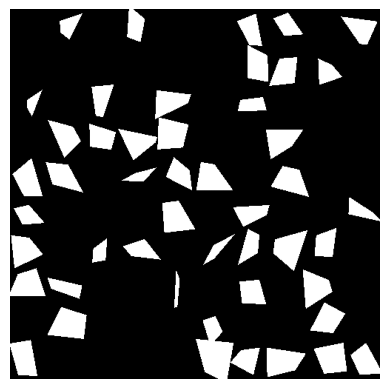

In [3]:
gridData = Create2dGrid(1)
gridData.Create()
gridData.ShowGrid(0)

In [4]:
torch.rand(2) * 100 - 1, torch.rand(2) * 500 - 1

(tensor([49.6326, 63.6183]), tensor([ 41.5043, 250.4470]))

In [5]:
def GenerateLinearTrajectory(seqLen=252, stateDim=2, start=None, goal=None, dt=0.1):
    if start is None:
        start = torch.rand(stateDim) * 100 
    
    if goal is None:
        goal = torch.rand(stateDim) * 500
        
    total_time = (seqLen - 1) * dt
    vel = (goal - start) / total_time
    
    traj = []
    pos = start.clone()
    for _ in range(seqLen):
        traj.append(pos.clone())
        pos = pos + vel * dt
        
    traj = torch.stack(traj, dim=0)
    noise = torch.randn_like(traj) * 0.01
    traj = traj + noise
    
    return traj

def Show2DTraj(giveTraj, points = []):
    trajToPlot = giveTraj
    x = trajToPlot[:, 0]
    y = trajToPlot[:, 1]
    plt.figure(figsize=(8, 6))
    for pnt in points:
        plt.scatter(np.array(pnt[0]), np.array(pnt[1]), color="purple", s=80, label="Obstacles")
    plt.plot(x.numpy(), y.numpy(), marker="o", markersize=2, color="blue", label="Trajectory")
    plt.scatter(x[0], y[0], color="green", s=80, label="Start")

    plt.scatter(x[-1], y[-1], color="red", s=80, label="Goal")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Drone Trajectory in 2D")
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
def ShowTrajInEnv(grid, traj, points=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.cpu().numpy().T, cmap="gray", origin="lower", extent=[0, 500, 0, 500])

    traj_np = traj.detach().cpu().numpy()
    x = traj_np[:, 0]
    y = traj_np[:, 1]

    plt.plot(x, y, color="cyan", linewidth=2, label="Trajectory", alpha=0.8)
    plt.scatter(x[0], y[0], color="green", s=100, label="Start", edgecolors='white', zorder=5)
    plt.scatter(x[-1], y[-1], color="red", s=100, label="Goal", edgecolors='white', zorder=5)
    if points:
        for pnt in points:
            plt.scatter(pnt[0], pnt[1], color="magenta", s=80, label="Point Obstacle")

    plt.title("Trajectory Overlaid on Environment")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [7]:
def CreateDistanceMap(bMask):
    dMap = distance_transform_edt(bMask == 0)
    return torch.from_numpy(dMap).float()

def CreateSignedDistanceMap(bMask):
    dist_outside = distance_transform_edt(bMask == 0)
    dist_inside = distance_transform_edt(bMask == 1)
    sdf = dist_outside - dist_inside
    return torch.from_numpy(sdf).float()

class MapLossFunction(nn.Module):
    def __init__(self, dist_map, w_smooth=0.1, w_space=0.2, w_length=0.3, w_collision=0.4, safety_radius=2.0):
        super().__init__()
        self.register_buffer('dist_map', dist_map)
        self.w_smooth = w_smooth
        self.w_space = w_space
        self.w_length = w_length
        self.w_collision = w_collision
        self.safety_radius = safety_radius

    def forward(self, traj):
        vel = traj[:, 1:] - traj[:, :-1]
        acc = vel[:, 1:] - vel[:, :-1]
        lossSmooth = (acc ** 2).sum()
        
        segmentLens = torch.norm(vel, dim=-1) + 1e-6
        meanLen = segmentLens.mean(dim=1, keepdim=True)
        lossSpace = ((segmentLens - meanLen) ** 2).sum()
        lossDistance = segmentLens.sum()
        
        grid_coords = (traj[..., :2] / 500) - 1.0
        grid_coords = grid_coords.unsqueeze(1)
        input_map = self.dist_map.unsqueeze(0).unsqueeze(0)
        dist_values = F.grid_sample(input_map, grid_coords, mode='bilinear', align_corners=True)
        diff = self.safety_radius - dist_values
        lossCollision = torch.relu(diff).pow(2).sum()

        tLoss = (self.w_smooth * lossSmooth) + \
                (self.w_space * lossSpace) + \
                (self.w_length * lossDistance) + \
                (self.w_collision * lossCollision)
        return tLoss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def OptimizeTrajectory(tau, start, end, map_data, iter=5000, lr=0.1):
    tau = tau.detach().clone().to(device).requires_grad_(True)
    map_dist = CreateSignedDistanceMap(map_data).to(device)
    sgdLoss = MapLossFunction(map_dist, safety_radius=40).to(device)
    
    optimizer = torch.optim.Adam([tau], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter, eta_min=1e-3)
    
    for _ in range(iter):
        optimizer.zero_grad()
        tau_batched = tau.unsqueeze(0) 
        
        tauLoss = sgdLoss(tau_batched)
        print(tauLoss.item())
        tauLoss.backward()
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            tau[0] = start.to(device)
            tau[-1] = end.to(device)
            
    return tau.detach().cpu()

In [10]:
def UpdateMap(map_tensor, start, end, radius=20):
    map_copy = map_tensor.clone()
    H, W = map_copy.shape
    
    for pt in [start, end]:
        cx, cy = int(pt[0]), int(pt[1])
        
        x0, x1 = max(0, cx - radius), min(H, cx + radius + 1)
        y0, y1 = max(0, cy - radius), min(W, cy + radius + 1)
        
        map_copy[x0:x1, y0:y1] = 0
        
    return map_copy

In [11]:
def ShowGrid(grid):
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.show()

In [12]:
a = torch.rand(2) * 500
b = torch.rand(2) * 500
a, b , int(torch.norm(a - b).item())

(tensor([396.5414, 376.7560]), tensor([ 45.7542, 223.0072]), 383)

154 464.8996276855469
torch.Size([154, 2])
33464.97265625
33326.81640625
33186.17578125
33047.71484375
32910.1015625
32772.4375
32635.25390625
32498.91015625
32362.927734375
32226.5546875
32089.77734375
31952.7578125
31816.14453125
31679.951171875
31544.28515625
31408.998046875
31273.806640625
31138.8359375
31007.83984375
30877.888671875
30747.908203125
30618.49609375
30489.521484375
30361.06640625
30233.142578125
30105.728515625
29979.337890625
29855.400390625
29733.8125
29610.248046875
29486.873046875
29362.509765625
29237.19140625
29111.9375
28987.091796875
28862.73828125
28738.91796875
28615.533203125
28492.57421875
28371.873046875
28251.19921875
28131.142578125
28011.802734375
27894.24609375
27779.142578125
27661.845703125
27543.88671875
27425.60546875
27307.388671875
27189.185546875
27070.505859375
26952.009765625
26833.80078125
26715.76953125
26597.8046875
26479.966796875
26362.814453125
26245.681640625
26130.509765625
26016.92578125
25904.044921875
25794.23046875
25686.14453125

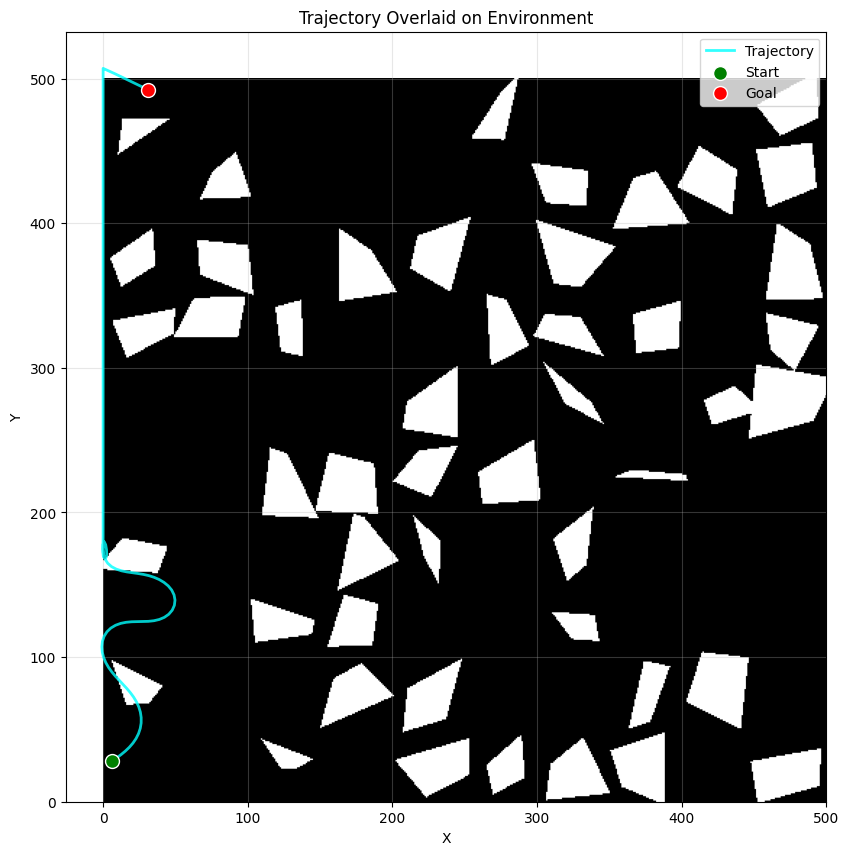

In [13]:
start, goal = torch.rand(2) * 100, torch.rand(2) * 500
gridEnv = UpdateMap(gridData.grid[0], start, goal)

print(int(torch.norm(start - goal).item() / 3), torch.norm(start - goal).item())
traj = GenerateLinearTrajectory(seqLen=int(torch.norm(start - goal).item() / 3),start = start, goal=goal)

print(traj.shape)

traj = OptimizeTrajectory(traj, start, goal, gridEnv)
ShowTrajInEnv(gridEnv, traj)

### A* Algorithm as a start

In [14]:
def CreateSignedDistanceMap(bMask):
    dist_outside = distance_transform_edt(bMask == 0)
    dist_inside = distance_transform_edt(bMask == 1)
    sdf = dist_outside - dist_inside
    return torch.from_numpy(sdf).float()

class MapLossFunction(nn.Module):
    def __init__(self, dist_map, ref_traj, w_smooth=0.2, w_space=0.0, 
                 w_length=0, w_collision=0.0, w_ref=0.8, safety_radius=0.5):
        super().__init__()
        self.register_buffer('dist_map', dist_map)
        self.register_buffer('ref_traj', ref_traj) 
        
        self.w_smooth = w_smooth
        self.w_space = w_space
        self.w_length = w_length
        self.w_collision = w_collision
        self.w_ref = w_ref
        self.safety_radius = safety_radius

    def forward(self, traj):
        vel = traj[:, 1:] - traj[:, :-1]
        acc = vel[:, 1:] - vel[:, :-1]
        lossSmooth = (acc ** 2).sum()
        
        segmentLens = torch.norm(vel, dim=-1) + 1e-6
        meanLen = segmentLens.mean(dim=1, keepdim=True)
        lossSpace = ((segmentLens - meanLen) ** 2).sum()
        
        lossDistance = segmentLens.sum()
        
        grid_coords = (traj[..., :2] / 500) - 1.0 
        grid_coords = grid_coords.unsqueeze(1)
        input_map = self.dist_map.unsqueeze(0).unsqueeze(0)
        dist_values = F.grid_sample(input_map, grid_coords, mode='bilinear', align_corners=True)
        
        diff = self.safety_radius - dist_values
        lossCollision = torch.relu(diff).pow(2).sum()

        lossRef = torch.mean((traj - self.ref_traj) ** 2)

        tLoss = (self.w_smooth * lossSmooth) + \
                (self.w_space * lossSpace) + \
                (self.w_length * lossDistance) + \
                (self.w_collision * lossCollision) + \
                (self.w_ref * lossRef)
        
        return tLoss
    
def OptimizeTrajectory(tau, start, end, map_data, iter=20, lr=0.2):
    map_dist = CreateSignedDistanceMap(map_data).to(device)
    sgdLoss = MapLossFunction(map_dist, tau.clone(), safety_radius=40).to(device)
    tau = tau.detach().clone().to(device).requires_grad_(True)
    
    optimizer = torch.optim.Adam([tau], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter, eta_min=1e-3)
    
    for _ in range(iter):
        optimizer.zero_grad()
        tau_batched = tau.unsqueeze(0) 
        
        tauLoss = sgdLoss(tau_batched)
        print(tauLoss.item())
        tauLoss.backward()
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            tau[0] = start.to(device)
            tau[-1] = end.to(device)
            
    return tau.detach().cpu()

In [15]:
counter = itertools.count()

def heuristic(a, b):
    return np.linalg.norm(a - b)

def Check(grid, i, j):
    i, j = int(i), int(j)
    H, W = grid.shape
    return 0 <= i < H and 0 <= j < W and not grid[i][j]

def AStar(grid, start, goal):
    start = tuple(start)
    goal  = tuple(goal)

    open_set = []
    heapq.heappush(open_set, (0, next(counter), start))

    g_cost = {start: 0.0}
    parent = {start: None}
    visited = set()

    step = 3
    dirs = [
        (step, 0), (-step, 0), (0, step), (0, -step),
        (step, step), (step, -step), (-step, step), (-step, -step)
    ]

    while open_set:
        _, _, current = heapq.heappop(open_set)

        if current in visited:
            continue

        visited.add(current)
        if ((current[0] - goal[0]) ** 2 + (current[1] - goal[1]) ** 2) ** 0.5 < step:
            parent[goal] = current
            break

        for dx, dy in dirs:
            nx, ny = current[0] + dx, current[1] + dy

            if not Check(grid, nx, ny):
                continue

            neighbor = (nx, ny)

            step_cost = np.sqrt(dx*dx + dy*dy)
            new_g = g_cost[current] + step_cost

            if neighbor not in g_cost or new_g < g_cost[neighbor]:
                g_cost[neighbor] = new_g
                parent[neighbor] = current
                f = new_g + heuristic(
                    np.array(neighbor),
                    np.array(goal)
                )
                heapq.heappush(
                    open_set,
                    (f, next(counter), neighbor)
                )
    if goal not in parent:
        return torch.empty((0, 2))

    path = []
    node = goal
    while node is not None:
        path.append(np.array(node))
        node = parent[node] 

    path.reverse()
    path = np.stack(path)
    return torch.from_numpy(path)

torch.Size([140, 2])


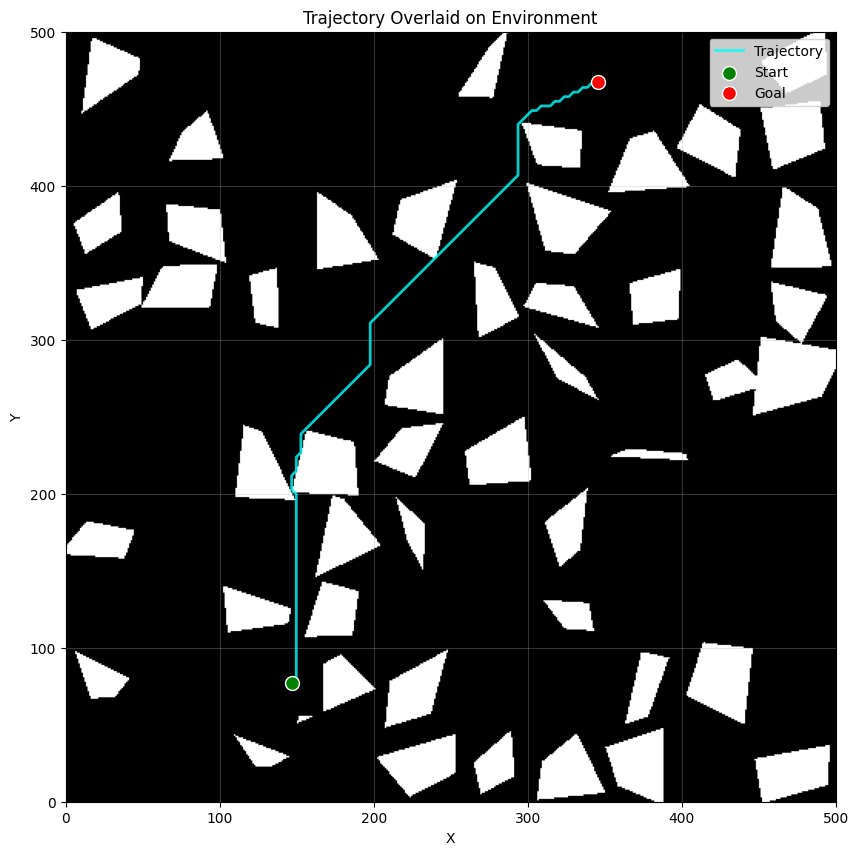

45.90656661987305
27.520465850830078
16.39000701904297
11.66135311126709
9.839634895324707
9.346517562866211
9.608818054199219
9.870222091674805
9.750245094299316
9.271170616149902
8.55976390838623
7.751946449279785
7.019587516784668
6.390370845794678
5.879289627075195
5.490690231323242
5.213129997253418
5.027894020080566
4.915899276733398
4.858455181121826


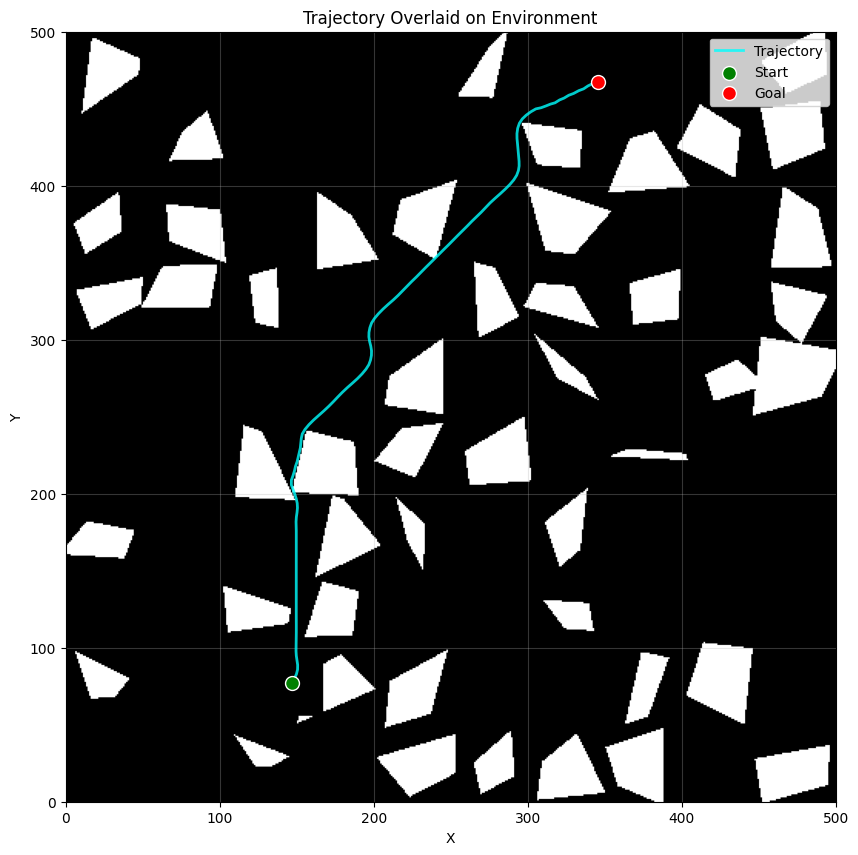

In [17]:
start, goal = torch.rand(2) * 500, torch.rand(2) * 500
# start, goal = torch.tensor([10, 10]), torch.tensor([300, 499])

gridEnv = UpdateMap(gridData.grid[0], start, goal)

traj = AStar(gridEnv, start.numpy(), goal.numpy())
print(traj.shape)

ShowTrajInEnv(gridEnv, traj)

traj = OptimizeTrajectory(traj, start, goal, gridEnv)
ShowTrajInEnv(gridEnv, traj)